A simple notebook demonstrating how to calculate a 95% confidence interval for an AUC 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import useful_rdkit_utils as uru
from lightgbm import LGBMClassifier
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

A couple of convenience functions

In [2]:
def smiles_to_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.Descriptors.MolWt(mol)


def log_ug_ml_to_logS(ug, molecular_weight):
    grams = 10**ug * 1e-6
    moles = grams / molecular_weight
    return np.log10(moles * 1000)

Read the data from [Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective](http://dx.doi.org/10.1021/acs.jcim.3c00160)

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/molecularinformatics/Computational-ADME/main/ADME_public_set_3521.csv")

Extract the solubility data

In [4]:
sol_df = df.dropna(subset="LOG SOLUBILITY PH 6.8 (ug/mL)")[["SMILES", "Internal ID", "LOG SOLUBILITY PH 6.8 (ug/mL)"]]
sol_df.columns = ["SMILES", "Name", "log_sol_ug_ml"]

Remove data without measured values

In [5]:
sol_df = sol_df.query("log_sol_ug_ml > 0").copy()

I don't relate to data in ug/ml, so I'm going to convert to the log of molar solubility (logS)

In [6]:
sol_df['mw'] = sol_df.SMILES.apply(smiles_to_molecular_weight)
sol_df['logS'] = [log_ug_ml_to_logS(a, b) for a, b in sol_df[["log_sol_ug_ml", "mw"]].values]

In [7]:
sol_df.head()

,SMILES,Name,log_sol_ug_ml,mw,logS
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,Mol1,0.089905,434.435,-5.548020
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,Mol2,0.550228,418.444,-5.071409
3,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,Mol4,1.657056,382.847,-3.925969
5,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,Mol6,1.033424,370.428,-4.535280
8,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,Mol9,0.933990,440.507,-4.709963


We'll classify everything with logS > -4 as soluble

In [8]:
sol_df['is_sol'] = sol_df.logS > -4
sol_df.is_sol = sol_df.is_sol.astype(int)

Plot the distribution

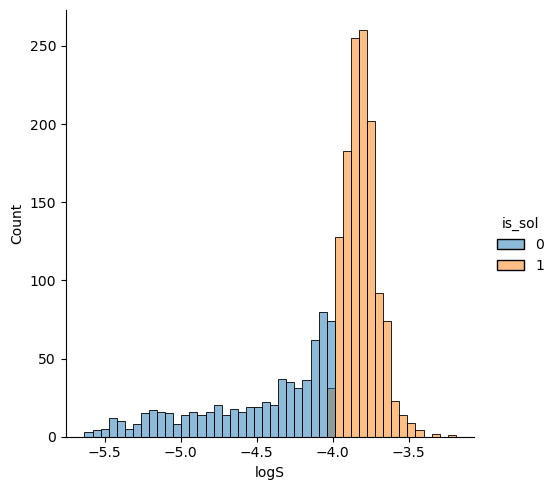

In [9]:
sns.displot(x="logS", hue="is_sol", data=sol_df);

Add a fingerprint to the dataframe

In [11]:
smi2fp = uru.Smi2Fp()
sol_df['fp'] = sol_df.SMILES.apply(smi2fp.get_np)

Split into training and test

In [12]:
train, test = train_test_split(sol_df)

Train the model

In [15]:
cls = LGBMClassifier(verbose=-1)

In [16]:
cls.fit(np.stack(train.fp), train.is_sol)

LGBMClassifier(verbose=-1)

Predict the test set

In [17]:
pred_vals = cls.predict_proba(np.stack(test.fp))[:, 1]

Calculate the AUC

In [18]:
roc_auc_score(test.is_sol, pred_vals)

0.7537309497442388

Define a function to bootstrap a 95% confidence interval for the AUC

In [19]:
def bootstrap_AUC(truth, pred, num_iterations=1000):
    """ Calculate the 95% confidence interval (CI) for an AUC
    :param truth: the true values
    :param pred: the predicted values
    :param num_iterations: number of bootstrap iterations
    :return: 95% CI lower bound, AUC, 95% CI upper bound
    """
    result_df = pd.DataFrame({"truth": truth, "pred": pred})
    auc_val = roc_auc_score(truth, pred)
    auc_list = []
    for _ in range(0, num_iterations):
        sample_df = resample(result_df)
        auc_list.append(roc_auc_score(sample_df.truth, sample_df.pred))
    return np.percentile(auc_list, 2.5), auc_val, np.percentile(auc_list, 97.5)

In [20]:
bootstrap_AUC(test.is_sol, pred_vals)

(0.7086174599074482, 0.7537309497442388, 0.7959183673469388)